In [1]:
#ライブラリ読み込み
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

In [2]:
#対数収益率の正規分布を仮定した長期投資シミュレーションモデル
class asset_model:
    #初期化時の処理
    def __init__(self, mu_y, s_y):
        #パーセント表記から少数へ変換
        mu_y = mu_y / 100
        s_y = s_y / 100
        #入力された対数収益率の年次リターン・リスク（標準偏差）を月次へ変換
        self.mu_m = mu_y /12
        self.s_m = s_y / np.sqrt(12)
    
    #対数収益率の長期モンテカルロシミュレーションを実施
    def run_mc(self, dur_y, n):
        #入力された投資期間を年→月へ変換
        dur_m = dur_y * 12
        # [(投資期間_月),(試行回数)]の正規分布N(μ,σ)に従う乱数行列として毎月の対数収益率を生成
        A1 = np.random.normal(self.mu_m, self.s_m,size=[dur_m,n])        
        #次元を拡張し、[(投資期間_月),(投資期間_月),(試行回数)]の行列とする
        A2 = np.tile(A1,[dur_m,1,1])
        #行列を転置し、[(試行回数),(投資期間_月),(投資期間_月)]の行列とする
        A3 = np.transpose(A2,(2,0,1))
        #各試行の上三角行列を取得
        A4 = np.triu(A3)
        #
        self.A = A4
        self.dur_m = dur_m
        print("Monte Carlo Calculation of "+ str(dur_y) + " years finished")
        
    #初期投資額x_init, 毎月積立額delta_mを投資した場合の資産推移を計算
    def exercise(self, x_init, delta_m):
        #月別の投資額のリスト
        x = delta_m * np.ones(self.dur_m)
        #初期投資額を追加
        x[0] = x[0] + x_init
        
        #総資産額のリスト
        ta_list = []
        #累計投資額のリスト
        capital = [] 
        
        #総資産額の推移を1年毎(12ヶ月毎)に集計する
        for i in range(11, self.dur_m,12):
            #集計時点までの対数収益率行列を切り出し
            A_tmp = self.A[:,:i+1, :i+1] 
            #集計時点までの投資額のリストを切り出し
            x_tmp = x[:i+1]
            #対数収益率行列の各行の和を計算
            A_tmp = A_tmp.sum(axis=2)
            #対数収益率から、価格変動比へ変換
            A_tmp = np.exp(A_tmp)
            #各試行の、投資期間経過後の資産額を計算
            ta = np.dot(A_tmp,x_tmp)
            #計算結果を格納
            ta_list.append(ta)
            
            #累計投資額を格納
            capital.append(x_tmp.sum())
            
        #1年毎の各種統計値を計算
        #平均
        mean = np.mean(ta_list, axis=1)
        #パーセンタイル値（np.percetileは下位○%を入力するが、出力としては上位○%の表記とする）
        p10 = np.percentile(ta_list,90,axis=1)
        p25 = np.percentile(ta_list,75,axis=1)
        p50 = np.percentile(ta_list,50,axis=1)
        p75 = np.percentile(ta_list,25,axis=1)
        p90 = np.percentile(ta_list,10,axis=1)
    
        year = np.arange(self.dur_m/12)+1
        
        #計算結果をDataFrameに格納
        df_result = pd.DataFrame(np.transpose([year,mean,p10,p25,p50,p75,p90,capital]),columns=["Year","Mean","P10","P25","P50","P75","P90","Capital"])
        pd.options.display.float_format = '{:.1f}'.format
        display(df_result)
            
        #グラフ出力
        left, width = 0.1, 0.65 
        bottom, height = 0.1, 0.65 
        fig_main = [left, bottom, width, height] #散布図の定義
        fig =plt.figure(figsize=(10,7)) 
        ax = fig.add_axes(fig_main)

        ax.fill_between(df_result["Year"],df_result["P10"],df_result["P90"], alpha=0.3, label="Range P10-P90")
        ax.fill_between(df_result["Year"],df_result["P25"],df_result["P75"], alpha=0.3, label="Range P25-P75")
        ax.plot(df_result["Year"],df_result["P50"], label="P50")
        ax.plot(df_result["Year"], df_result["Capital"], label="Capital")
        ax.set_ylim(0, max(df_result["P10"])*1.1)
        ax.set_xlim(1,max(df_result["Year"]))
        ax.set_xlabel("Year")
        ax.set_ylabel("Total assets")
        ax.grid(True)
        ax.legend()    
        

Monte Carlo Calculation of 10 years finished


,Year,Mean,P10,P25,P50,P75,P90,Capital
0,1.0,126.6,147.4,136.7,125.6,115.3,107.0,120.0
1,2.0,267.0,328.4,294.8,262.5,233.8,212.0,240.0
2,3.0,421.8,542.1,474.9,411.1,357.4,315.4,360.0
3,4.0,594.1,788.4,676.6,574.3,487.4,424.4,480.0
4,5.0,783.3,1077.4,902.1,748.7,625.8,533.7,600.0
5,6.0,994.0,1397.7,1153.3,943.9,769.6,649.1,720.0
6,7.0,1226.3,1776.0,1440.3,1151.8,924.9,767.0,840.0
7,8.0,1483.7,2208.5,1756.8,1377.8,1092.7,890.3,960.0
8,9.0,1767.3,2684.7,2102.2,1630.6,1266.9,1021.5,1080.0
9,10.0,2077.8,3221.8,2490.6,1888.4,1456.0,1157.7,1200.0


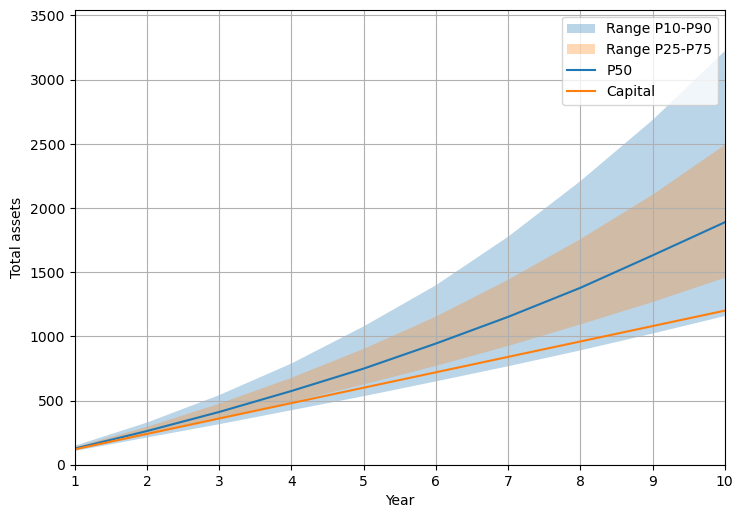

In [3]:
# 期待対数収益率、標準偏差（%,年換算）
mu = 8
s = 20

#リターンmu、リスクsのモデルを定義
model = asset_model(mu,s)

# 投資期間（年）
dur_y = 10
# 試行回数
n = 20000

#投資期間dur_y、試行回数nのモンテカルロシミュレーションを実行
model.run_mc(dur_y,n)

# 初期投資額
x_init = 0
# 毎月積立額
delta_m = 10

#初期投資x_init、毎月delta_mの積立投資を行った場合の資産推移を計算
model.exercise(x_init,delta_m)

,Year,Mean,P10,P25,P50,P75,P90,Capital
0,1.0,1325.0,1676.5,1488.6,1300.7,1133.1,1003.6,1200.0
1,2.0,1466.2,2024.2,1705.1,1408.9,1164.2,984.0,1200.0
2,3.0,1620.8,2384.2,1929.3,1528.1,1205.9,977.5,1200.0
3,4.0,1794.9,2767.7,2171.1,1655.2,1263.4,993.0,1200.0
4,5.0,1984.5,3174.7,2423.1,1800.4,1321.0,1017.1,1200.0
5,6.0,2196.8,3640.1,2710.9,1948.0,1401.6,1039.1,1200.0
6,7.0,2430.0,4171.6,3019.7,2100.8,1476.8,1072.3,1200.0
7,8.0,2690.3,4735.6,3346.6,2289.3,1562.6,1113.5,1200.0
8,9.0,2973.3,5365.2,3729.2,2489.2,1661.0,1156.0,1200.0
9,10.0,3281.0,6047.5,4121.7,2686.4,1763.6,1200.5,1200.0


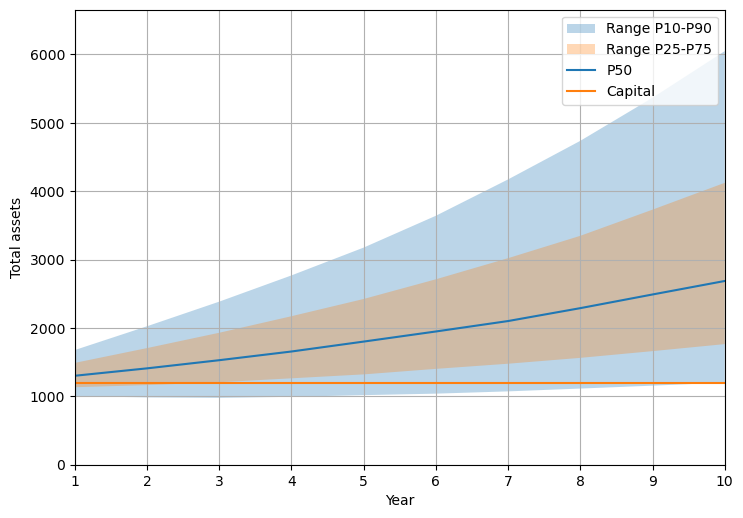

In [4]:
# 初期投資額
x_init = 1200
# 毎月積立額
delta_m = 0

#初期投資x_init、毎月delta_mの積立投資を行った場合の資産推移を計算
model.exercise(x_init,delta_m)

以下、コード説明用

In [5]:
#print出力のフォーマット調整
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=100)

In [6]:
dur_m = 1 * 12
mu_m = 0.09 / 12
s_m = 0.20 / np.sqrt(12)
n = 5

A1 = np.random.normal(mu_m,s_m,size=[dur_m,n])
print(np.shape(A1))
print(A1)

(12, 5)
[[ 0.01   0.072 -0.027 -0.091  0.045]
 [ 0.112  0.06  -0.02   0.004  0.093]
 [-0.01   0.067  0.07  -0.017  0.064]
 [-0.007 -0.023  0.019 -0.127 -0.075]
 [ 0.018 -0.001  0.052 -0.002  0.009]
 [-0.022  0.073  0.022 -0.105 -0.014]
 [ 0.012 -0.02   0.065  0.008  0.033]
 [ 0.002  0.088  0.029  0.107 -0.005]
 [-0.084 -0.025  0.046  0.044  0.006]
 [-0.027  0.029  0.014 -0.027  0.078]
 [ 0.044  0.044  0.006  0.008 -0.07 ]
 [-0.028  0.073  0.005 -0.004  0.04 ]]


In [7]:
A2 = np.tile(A1,[dur_m,1,1])
print(np.shape(A2))
print(A2)

(12, 12, 5)
[[[ 0.01   0.072 -0.027 -0.091  0.045]
  [ 0.112  0.06  -0.02   0.004  0.093]
  [-0.01   0.067  0.07  -0.017  0.064]
  [-0.007 -0.023  0.019 -0.127 -0.075]
  [ 0.018 -0.001  0.052 -0.002  0.009]
  [-0.022  0.073  0.022 -0.105 -0.014]
  [ 0.012 -0.02   0.065  0.008  0.033]
  [ 0.002  0.088  0.029  0.107 -0.005]
  [-0.084 -0.025  0.046  0.044  0.006]
  [-0.027  0.029  0.014 -0.027  0.078]
  [ 0.044  0.044  0.006  0.008 -0.07 ]
  [-0.028  0.073  0.005 -0.004  0.04 ]]

 [[ 0.01   0.072 -0.027 -0.091  0.045]
  [ 0.112  0.06  -0.02   0.004  0.093]
  [-0.01   0.067  0.07  -0.017  0.064]
  [-0.007 -0.023  0.019 -0.127 -0.075]
  [ 0.018 -0.001  0.052 -0.002  0.009]
  [-0.022  0.073  0.022 -0.105 -0.014]
  [ 0.012 -0.02   0.065  0.008  0.033]
  [ 0.002  0.088  0.029  0.107 -0.005]
  [-0.084 -0.025  0.046  0.044  0.006]
  [-0.027  0.029  0.014 -0.027  0.078]
  [ 0.044  0.044  0.006  0.008 -0.07 ]
  [-0.028  0.073  0.005 -0.004  0.04 ]]

 [[ 0.01   0.072 -0.027 -0.091  0.045]
  [ 0.112

In [8]:
A3 = np.transpose(A2,(2,0,1))
print(np.shape(A3))
print(A3)

(5, 12, 12)
[[[ 0.01   0.112 -0.01  -0.007  0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.01   0.112 -0.01  -0.007  0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.01   0.112 -0.01  -0.007  0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.01   0.112 -0.01  -0.007  0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.01   0.112 -0.01  -0.007  0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.01   0.112 -0.01  -0.007  0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.01   0.112 -0.01  -0.007  0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.01   0.112 -0.01  -0.007  0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.01   0.112 -0.01  -0.007  0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.01   0.112 -0.01  -0.007  0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.01   0.112 -0.01  -0.007  0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.01   0.112 -0.

In [9]:
A4 = np.triu(A3)
print(np.shape(A4))
print(A4)

(5, 12, 12)
[[[ 0.01   0.112 -0.01  -0.007  0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.     0.112 -0.01  -0.007  0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.     0.    -0.01  -0.007  0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.     0.     0.    -0.007  0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.     0.     0.     0.     0.018 -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.     0.     0.     0.     0.    -0.022  0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.     0.     0.     0.     0.     0.     0.012  0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.     0.     0.     0.     0.     0.     0.     0.002 -0.084 -0.027  0.044 -0.028]
  [ 0.     0.     0.     0.     0.     0.     0.     0.    -0.084 -0.027  0.044 -0.028]
  [ 0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.027  0.044 -0.028]
  [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.044 -0.028]
  [ 0.     0.     0.

In [10]:
a = A4.sum(axis=2)
print(np.shape(a))
print(a)

(5, 12)
[[ 0.02   0.01  -0.102 -0.092 -0.084 -0.103 -0.081 -0.093 -0.095 -0.011  0.015 -0.028]
 [ 0.438  0.366  0.306  0.239  0.261  0.263  0.189  0.209  0.121  0.146  0.117  0.073]
 [ 0.28   0.307  0.327  0.256  0.237  0.185  0.163  0.099  0.07   0.024  0.01   0.005]
 [-0.2   -0.109 -0.114 -0.097  0.03   0.032  0.137  0.129  0.022 -0.022  0.005 -0.004]
 [ 0.204  0.159  0.066  0.002  0.077  0.068  0.081  0.049  0.054  0.048 -0.03   0.04 ]]


In [11]:
a = np.exp(a)
print(np.shape(a))
print(a)

(5, 12)
[[1.021 1.01  0.903 0.912 0.919 0.902 0.922 0.911 0.909 0.989 1.016 0.972]
 [1.55  1.442 1.357 1.269 1.299 1.3   1.208 1.233 1.129 1.157 1.124 1.076]
 [1.323 1.359 1.386 1.292 1.267 1.203 1.177 1.104 1.073 1.024 1.01  1.005]
 [0.819 0.896 0.892 0.907 1.031 1.033 1.147 1.137 1.022 0.978 1.005 0.996]
 [1.226 1.172 1.068 1.002 1.08  1.07  1.085 1.05  1.055 1.049 0.97  1.041]]


In [12]:
x = np.ones(12)
ta = np.dot(a,x)
print(np.shape(ta))
print(ta)

(5,)
[11.387 15.145 14.225 11.863 12.867]
